In [13]:
# Neural Network libraries
import torch
import torch.nn as nn
from torch.distributions import Normal as torchNormal
import gym

# Custom env
from CustomEnv import Env as ENV

# Libraries for the RL training
from utils.NetModels import Actor, Critic, Agent, DummyActor, ImmobileActor
from utils.AuxFuncs import (save_net, load_net, plot_stats)
from utils.TrainingFuncs import train_agent
from utils.RlAlgorithms import SAC

# Libraries for the OSC
from abr_control.arms.mujoco_config import MujocoConfig as ArmConfig
from abr_control.interfaces.mujoco import Mujoco as MujocoInterface
from abr_control.controllers.osc2 import OSC2
from abr_control.controllers.joint_limit_controller import JointLimitsController
from abr_control.controllers.hierarchy_controller import HierarchyController

# Auxiliar libraries
import numpy as np
import matplotlib.pyplot as plt
import glfw
from collections import deque
from random import sample
from copy import deepcopy

In [14]:
# --- Enviroment Instantiation ---

xml_model = "franka_research3.xml"    
#folder_path = "c:\\Users\\user\\Desktop\\folder\\assets"
folder_path = "c:\\Users\\piril\\Desktop\\Codigo Final\\assets"

DOF = 7
FINGER_DOF = 2
initial_pose = np.array([0, -np.pi/4, 0, -3*np.pi/4, 0, np.pi/2, np.pi/4])

env = ENV(folder_path + "\\" + xml_model, DOF = DOF,
                   FINGER_DOF = FINGER_DOF, initial_pose = initial_pose)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [15]:
class ControllerWrapper():


    def __init__(self, dist_thresh1, angle_thresh,
                 grab_dist_thresh, aux_control_bool, DOF, FINGER_DOF):
        self.null_control = None
        self.dist_thresh1 = dist_thresh1
        self.angle_thresh = angle_thresh
        self.grab_dist_thresh = grab_thresh
        self.grab_finger_thresh = 0.01
        self.DOF = DOF 
        self.FINGER_DOF = FINGER_DOF
    
        self.fruit_grabbed = False
        self.aux_control_bool = aux_control_bool
        self.aux_control_active = False
        
        self.custom_target = None
        self.agent_null_torque = np.array([0]*self.DOF)
        
    def pre_control_func(self, agent_target, agent_null_torque, env_dict):
        
        if np.any(self.custom_target):
            target = self.custom_target.copy()
            self.custom_target = None
            
        else:
            target = env.get_body_com("target")
            
        target_dist = np.linalg.norm(target - env.get_body_com("EE"))
        target_pos = env._dict["target_pos"]
        target_angle = env._dict["target_angle"]
        finger_angles = env._dict["finger_angles"] 
        self.agent_null_torque = agent_null_torque
    
        if self.aux_control_active:
            agent_target = target_pos
        else:
            if self.aux_control_bool:
                if target_dist < self.dist_thresh1 and target_angle <= self.angle_thresh:
                    self.aux_control_active = True
                    agent_target = target_pos
                    
        finger_act = None

        if target_dist < self.grab_dist_thresh:

            finger_act = np.array([1] * self.FINGER_DOF) * -5
            fing_closed_bool = abs(finger_angles) < self.grab_finger_thresh 
            if np.any(fing_closed_bool):
                self.fruit_grabbed = True
                self.aux_control_active = True
        else:
            if self.fruit_grabbed:
                finger_act = np.array([1] * self.FINGER_DOF) * -7
        finger_act = None
        return agent_target, finger_act
            
    def generate(self, q, dq, target_velocity=None):
        if not self.aux_control_active:
            agent_null_torque = self.agent_null_torque
        else:
            agent_null_torque = np.array([0]*self.DOF)
            
        return agent_null_torque
    
    def reset(self, custom_target = None):
        self.aux_control_active = False
        self.fruit_grabbed = False
        
        self.agent_null_torque = np.array([0]*self.DOF)
        
        if np.any(custom_target):
            self.custom_target = custom_target

In [18]:
# --- Controller gains ---
dt = 0.001
kp = 1 
kv = 2
ki = 0.0

# --- Auxiliar controller parameters---
dist_thresh1 = 0.15 
angle_thresh = 60 * (np.pi/180)
grab_thresh = 0.03
aux_control_bool = True
torque_safety_factor = 0.9 # porcentaje del torque maximo que se utiliza
min_torque = env.action_space.low * torque_safety_factor
max_torque = env.action_space.high * torque_safety_factor

# --- Parametros del controlador de seguridad ---

danger_perc = 0.95 
warning_perc = 0.9 
env.safe_perc = 0.5 

joint_mid_range = (env.q_limit_high + env.q_limit_low)/2
joint_range = ((env.q_limit_high - env.q_limit_low)/2) * danger_perc
min_joint_angles = joint_mid_range - joint_range
max_joint_angles = joint_mid_range + joint_range

joint_angles_thresh = joint_range *  (1 - warning_perc)  
kp_safe = env.action_space.high * 1 
kd_safe = env.action_space.high * 0 

ctrlr_dof=[True, True, True, False, False, False] 
vmax = None 

robot_config = ArmConfig(xml_model, folder = folder_path)
interface = MujocoInterface(robot_config, dt=dt, visualize = False)
env.sim.model.opt.timestep = dt
interface.connect(sim = env.sim) 


null_controller = ControllerWrapper(dist_thresh1, angle_thresh,
                 grab_thresh, aux_control_bool, DOF, FINGER_DOF)

op_space_controller = OSC2(robot_config, kp = kp, kv = kv, ki = ki, vmax = vmax)

safety_controller = JointLimitsController(robot_config = robot_config, min_joint_angles = min_joint_angles,
                      max_joint_angles = max_joint_angles, joint_angles_thresh = joint_angles_thresh,
                      k_p = kp_safe, k_d = kd_safe)

controller = HierarchyController(robot_config = robot_config, safe_controller = safety_controller,
                                 min_torque = min_torque, max_torque = max_torque,
                                 op_space_controller = op_space_controller, null_controllers= [null_controller])

c:\Users\piril\Desktop\Codigo Final\assets\franka_research3.xml
MuJoCo session created


In [19]:
# --- Neural network architecture definition ---
def net_architecture(input_dim, hidden_dim):
    return nn.Sequential(nn.Linear(input_dim, hidden_dim),
                         nn.LayerNorm(hidden_dim),
                         nn.LeakyReLU(),
                         nn.Linear(hidden_dim, hidden_dim),
                         nn.LayerNorm(hidden_dim),
                         nn.LeakyReLU())

In [20]:
# --- Definition of the actor/critics networks---

action_dim = 10 # x_desired + t_null
state_dim = env.observation_space.shape[0]
hidden_dim = 500 

max_action_range = torch.Tensor(np.concatenate((np.array([0.45] * 3),
                                                max_torque * 0.5))).to(device) 

min_std = 0.01 
max_std = 0.4

actor = Actor("SAC", net_architecture(state_dim, hidden_dim), hidden_dim, action_dim, max_action_range,
              min_std, max_std).to(device)
 
q1_critic = Critic("SAC", net_architecture(state_dim + action_dim, hidden_dim), hidden_dim).to(device)
target_q1_critic = Critic("SAC", net_architecture(state_dim + action_dim, hidden_dim), hidden_dim).to(device)

q2_critic = Critic("SAC", net_architecture(state_dim + action_dim, hidden_dim), hidden_dim).to(device)
target_q2_critic = Critic("SAC", net_architecture(state_dim + action_dim, hidden_dim), hidden_dim).to(device)

In [25]:
class AgentEnv():

    
    def __init__(self, env, skip_steps, controller, aux_controller, max_steps, max_range,
                 ctrl_const, crash_const, sucess_const, time_const,
                 danger_perc, warning_perc, aux_control = False):
        
        self.env = env
        self.skip_steps = skip_steps
        self.controller = controller
        self.aux_controller = aux_controller
        self._max_episode_steps = max_steps  
        self.env._max_episode_steps = self._max_episode_steps * self.skip_steps
        self.max_range = max_range
        self.ctrl_const = ctrl_const
        self.crash_const = crash_const
        self.time_const = time_const
        self.final_success_const = sucess_const
        self.success_bool = False
        self.n_actions = env.action_space.shape[0]
        self.q = np.zeros(self.n_actions) * 2 
        self.dq = np.zeros(self.n_actions)
        self.DOF = env.DOF
        
        self.render = False
        self.danger_perc = danger_perc
        self.warning_perc = warning_perc
        
        self.dist_measure = 0
        self.energy_measure = 0
        self.manipu_measure = 0
        self.finish_time = np.inf
        
        self.TESTING = False

        class Aux():
            pass
        self.action_space = Aux()
        self.action_space.sample = lambda: np.random.uniform(-self.max_range, self.max_range, 3 + self.DOF)

    def draw_obj(self, agent_target, agent_null_torque):
        
        robot_joint_index_ini = self.env.model.geom_name2id('link_1_visual_geom')
        robot_joint_indexes = np.arange(robot_joint_index_ini, robot_joint_index_ini + 2 * self.DOF, 2)
        
        joint_range = (self.env.q_limit_high - self.env.q_limit_low) 
        high_dist = self.env.q_limit_high * self.danger_perc - self.env.q 
        low_dist = self.env.q - self.env.q_limit_low * self.danger_perc
        min_dist = np.minimum(high_dist, low_dist)

        safe_index = min_dist > joint_range/2 * (1 - self.warning_perc)
        danger_index = min_dist <= 0
        warning_index = ~ safe_index & ~ danger_index
        
        safe_joints = robot_joint_indexes[safe_index]
        warning_joints = robot_joint_indexes[warning_index]
        danger_joints = robot_joint_indexes[danger_index]
        
        self.env.model.geom_rgba[safe_joints] = np.array([0.3, 0.9, 0.2, 0.9])
        self.env.model.geom_rgba[warning_joints] = np.array([0.9, 0.9, 0.2, 0.9])
        self.env.model.geom_rgba[danger_joints] = np.array([0.9, 0.3, 0.2, 1])
        
        self.env.data.mocap_pos[2] = agent_target

    def step(self, agent_output, stop_early = True):
        agent_target = agent_output[0:3]
        agent_null_torque = agent_output[3:]
        
        agent_target = self.env.get_body_com("EE") + agent_target
        
        if self.reset_step:
            finger_act = None
            self.reset_step = False
        else:
            agent_target, finger_act = self.aux_controller.pre_control_func(agent_target,
                                                                            agent_null_torque,
                                                                            self.env._dict)

        if self.aux_controller.aux_control_active and not self.success_bool:
            self.success_bool = True

        step_reward = 0
        for t in range(self.skip_steps):
            if self.TESTING:
                self.draw_obj(agent_target, agent_null_torque)
        
            if self.render:
                self.env.render()
            
            target = np.hstack([agent_target, np.array([0, 0, 0]),])
            
            action = self.controller.generate(q=self.q, dq=self.dq, target = target)
            ob, reward, done, dict_ = self.env.step(action, ctrl_const = self.ctrl_const,
                                                    crash_const = self.crash_const,
                                                    sucess_const = self.final_success_const,
                                                    time_const = self.time_const,
                                                    finger_act = finger_act,
                                                    fruit_grabbed =  self.aux_controller.fruit_grabbed,
                                                    testing = self.TESTING)
            step_reward += reward  
            self.q = self.env.q
            self.dq = self.env.dq
            
            if done and stop_early:
                break
        
        self.dist_measure = self.env.distance_measure
        self.energy_measure = self.env.energy_measure
        self.collision = self.env.collision
        self.finish_time = self.env.data.time
        
        return ob, step_reward, done, dict_
    
    def seed(self, num):
        self.env.seed(num)
    
    def reset(self, area_perc = 1, repeat_perc = 0, custom_target_delta = None):
        self.dist_measure = 0
        self.energy_measure = 0
        self.manipu_measure = 0
        self.success_bool = False
        self.env.area_perc = area_perc 
        self.env.repeat_perc = repeat_perc
        self.env._max_episode_steps = self._max_episode_steps * self.skip_steps
        
        self.env.reset()
        if np.any(custom_target_delta):
            self.env.data.mocap_pos[1] = self.env.get_body_com("EE") + custom_target_delta
        
        self.q = self.env.q
        self.dq = self.env.dq.copy()
        self.aux_controller.reset()
        self.reset_step = True 

# Reward design parameter gains
ctrl_const = -0.03 
crash_const = -5 
sucess_const = 2.2 
time_const = -0.3

# time = max_steps * skip_steps * dt
max_steps = 20 
skip_steps = 500
aux_control = True

agent_env = AgentEnv(env = env, skip_steps = skip_steps, controller = controller, aux_controller = null_controller,
                     max_steps = max_steps, max_range = max_action_range.cpu().numpy(), ctrl_const = ctrl_const,
                     crash_const = crash_const, sucess_const = sucess_const,
                     time_const = time_const, aux_control = aux_control,
                     danger_perc = danger_perc, warning_perc = warning_perc)

In [26]:
# --- Hyperparameter definition ---

# Instanciacion del agente
algorithm_name = "SAC"
max_mem_lenght = 50000 
max_score_mem = 100 
max_stats_mem = 40
batch_size = 256  
epochs = 60000

epsilon = 0.01 
gamma = 0.99 
actor_lr = 0.001
q_critic_lr = 0.001
tau = 0.005 
actor_lr_interval = 0.5 
critic_lr_interval = 0.25
exp_epochs = 32

agent = Agent(algorithm_name, max_mem_lenght, max_score_mem, max_stats_mem,
              batch_size, max_steps, state_dim, action_dim, dist_thresh1, device, epsilon, gamma)

target_alpha = -torch.Tensor((action_dim, )).to(device).item() 
log_alpha = torch.zeros(1, requires_grad=True, device=device)
alpha_opt = torch.optim.Adam([log_alpha], lr=q_critic_lr)

actor_opt = torch.optim.Adam(actor.parameters(), lr = actor_lr)
q1_critic_opt = torch.optim.Adam(q1_critic.parameters(), lr = q_critic_lr)
q2_critic_opt = torch.optim.Adam(q2_critic.parameters(), lr = q_critic_lr)

rl_algorithm = SAC

print_interval = max(int(epochs/1000), 1)
save_interval =  max(int(epochs/10), 1)
save_file_name = "Actor" 

alpha_max_epoch = int(epochs * 0.9) 
nets_list = [actor, q1_critic, q2_critic]
targ_nets_list = [None, target_q1_critic, target_q2_critic]
opt_list = [actor_opt, q1_critic_opt, q2_critic_opt, alpha_opt]
agent_kwargs = {"squashed": True, "stability_const": 0.00001}
repeat_max_perc = 0.6

In [27]:
# --- Se entrena al agente ---

# revisar si funciona bien lo de guardar el mejooor agente

(stats_history,
 best_nets, final_nets) = train_agent(rl_algorithm = rl_algorithm, agent = agent, env = agent_env, device = device,
                                      epochs = epochs, exp_epochs = exp_epochs, print_interval = print_interval,
                                      save_interval = save_interval, save_file_name = save_file_name,
                                      nets_list = nets_list, targ_nets_list = targ_nets_list, opt_list = opt_list,
                                      actor_lr_interval = actor_lr_interval, critic_lr_interval = critic_lr_interval,
                                      
                                      gamma = gamma, agent_kwargs = agent_kwargs, tau = tau, target_alpha = target_alpha,
                                      log_alpha = log_alpha, repeat_max_perc = repeat_max_perc)

actor2 = Actor("SAC", net_architecture(state_dim, hidden_dim), hidden_dim, action_dim, max_action_range,
              min_std, max_std).to(device)

actor2.load_state_dict(deepcopy(best_nets[0]))

Generating initial memories...
The exploration phase has finished!
Average score: -48.75
Starting training...
'Actor' object has no attribute 'mu_layer'
The training has finished!
Recovering the best agent of epoch: None ...
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\piril\anaconda3\envs\hectos\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\piril\AppData\Local\Temp\ipykernel_21428\693799524.py", line 6, in <cell line: 6>
    best_nets, final_nets) = train_agent(rl_algorithm = rl_algorithm, agent = agent, env = agent_env, device = device,
  File "C:\Users\piril\Desktop\Codigo Final\utils\TrainingFuncs.py", line 270, in train_agent
TypeError: 'NoneType' object is not subscriptable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\piril\anaconda3\envs\hectos\lib\site-packages\IPython\core\interactiveshell.py", line 1992, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "C:\Users\piril\anaconda3\envs\hectos\lib\site-packages\IPython\core\ultratb.py", line 1118, in structured_traceback
    return FormattedTB

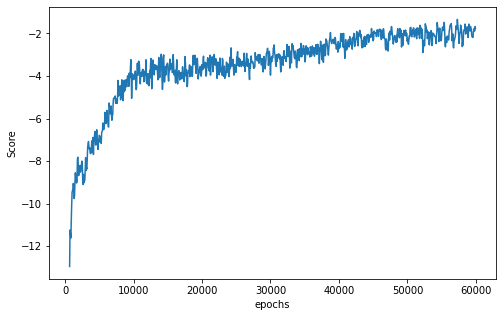

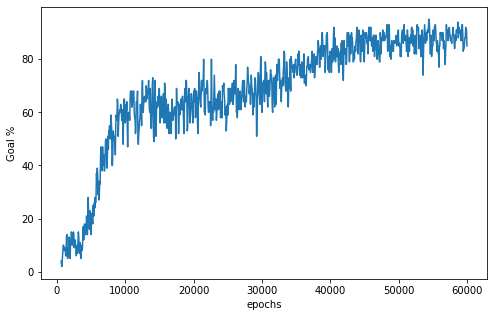

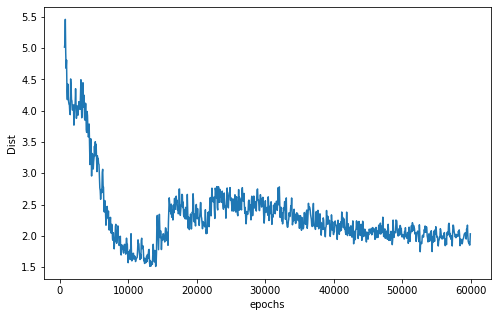

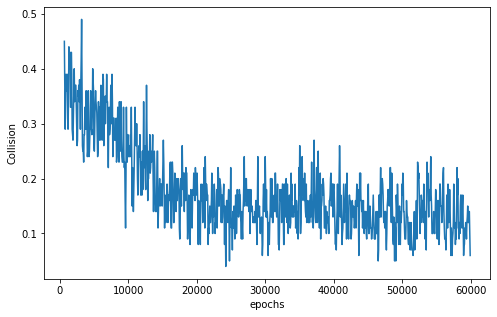

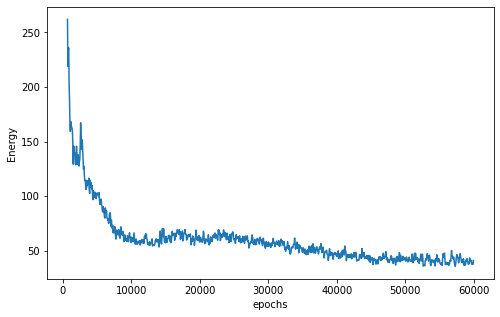

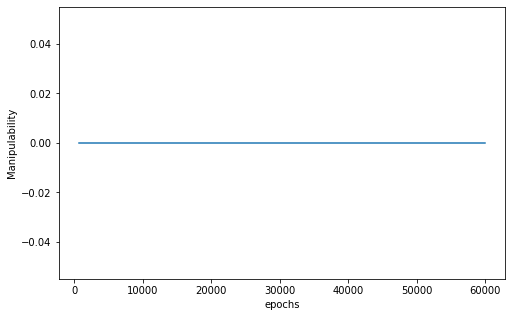

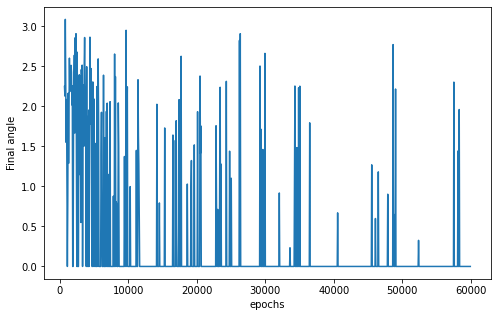

In [13]:
plot_stats(stats_history, stats_name, epochs, print_interval)

Creating window glfw
Target: [-0.21833669 -0.18331484  0.39465094]
colision?: False
success?: True
total_reward: 18475.535


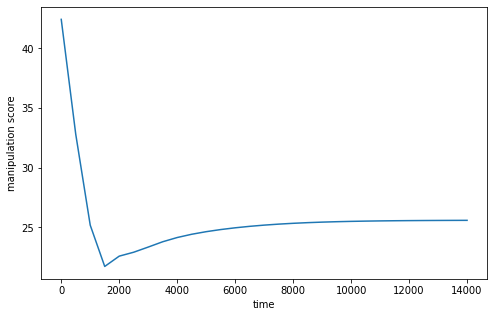

In [122]:
# --- Testing ---

OSC_actor = DummyActor(env, action_dim = action_dim, max_range = max_action_range)

env.fixed_ini = True
agent_env.TESTING = True
NEURAL_CONTROLLER = False

test_steps = 30

if NEURAL_CONTROLLER:
    current_actor = actor2
else:
    current_actor = base_case_actor
    
glfw.init()
agent_env._max_episode_steps = test_steps
agent.reset(agent_env)
test_steps -= 1 

for t in range(test_steps):
    
    env.render()
    mu, std, V, Q, total_reward, done = agent.test(agent_env, current_actor, device,
                                                   critic = None, q_critic = None,
                                                   stop_early = False)
    
    mani_array[t] = agent_env.manipulation_score
    
print("colision: " + str(env.collision))
print("success: " + str(agent.goal_reached))
print("total_reward: " + str(total_reward))
glfw.terminate() 
env.close()